In [1]:
from collections import defaultdict
import pandas as pd
import numpy as np
import io
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
# nltk.download('all') # Download only required or all -> press d, type all, type quit after
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords # not using these stopwords, still may be useful in the future
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn
from nltk.stem.snowball import SnowballStemmer
from sklearn.model_selection import train_test_split

from sklearn.metrics import precision_score, accuracy_score, f1_score, confusion_matrix, recall_score, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier

In [2]:
train_path = "content/training.csv"
val_path = "content/validation.csv"
test_path = "content/test.csv"

train_df = pd.read_csv(train_path)
val_df = pd.read_csv(val_path)
test_df = pd.read_csv(test_path)

In [3]:
def tokenize(column):
    tokens = nltk.word_tokenize(column)
    return [w for w in tokens if w.isalpha()]  

In [4]:
train_df['tokenized'] = train_df.apply(lambda x: tokenize(x['text']), axis=1)
val_df['tokenized'] = val_df.apply(lambda x: tokenize(x['text']), axis=1)
test_df['tokenized'] = test_df.apply(lambda x: tokenize(x['text']), axis=1)

In [5]:
lmtzr = WordNetLemmatizer()
train_df['lemmatized'] = train_df['tokenized'].apply(lambda lst:[lmtzr.lemmatize(word) for word in lst])
train_df.lemmatized = train_df.lemmatized.str.join(sep=' ')

val_df['lemmatized'] = val_df['tokenized'].apply(lambda lst:[lmtzr.lemmatize(word) for word in lst])
val_df.lemmatized = val_df.lemmatized.str.join(sep=' ')

test_df['lemmatized'] = test_df['tokenized'].apply(lambda lst:[lmtzr.lemmatize(word) for word in lst])
test_df.lemmatized = test_df.lemmatized.str.join(sep=' ')

stemmer = SnowballStemmer("english")
train_df['stemmed'] = train_df.tokenized.map(lambda l: [stemmer.stem(word) for word in l])
train_df.stemmed = train_df.stemmed.str.join(sep=' ')

val_df['stemmed'] = val_df.tokenized.map(lambda l: [stemmer.stem(word) for word in l])
val_df.stemmed = val_df.stemmed.str.join(sep=' ')

test_df['stemmed'] = test_df.tokenized.map(lambda l: [stemmer.stem(word) for word in l])
test_df.stemmed = test_df.stemmed.str.join(sep=' ')

In [6]:
train_labels = np.array(train_df['label'])
val_labels = np.array(val_df['label'])
test_labels = np.array(test_df['label'])

In [7]:
Encoder = LabelEncoder()
train_labels = Encoder.fit_transform(train_labels)
val_labels = Encoder.fit_transform(val_labels)
test_labels = Encoder.fit_transform(test_labels)

In [10]:
# stop = ['a', 'an', 'the', 'and', 'is', 'are', 'am', 'for', 'in', 'of', 'at', 'to', 's', 'www', 'again', 'against', 'among', 'amongst', 'little', 'lot', 'had', 'across', 'also', 'after', 'between', 'might', 'may', 'should']

Tfidf_vect = TfidfVectorizer(max_features=5000, stop_words='english')
train_X_Tfidf = Tfidf_vect.fit_transform(train_df['lemmatized'])
test_X_Tfidf = Tfidf_vect.transform(test_df['lemmatized'])
val_X_Tfidf = Tfidf_vect.transform(val_df['lemmatized'])

cv = CountVectorizer(stop_words='english')
train_X_cv = cv.fit_transform(train_df['lemmatized'])
val_X_cv = cv.transform(val_df["lemmatized"])
test_X_cv = cv.transform(test_df["lemmatized"])

# train_X_Tfidf = Tfidf_vect.fit_transform(train_df['stemmed'])
# test_X_Tfidf = Tfidf_vect.transform(test_df['stemmed'])
# val_X_Tfidf = Tfidf_vect.transform(val_df['stemmed'])

In [13]:
for c in [10, 1.0, 0.1]:
    for kernel in ['rbf', 'poly', 'sigmoid']:
        if kernel == 'rbf':
            for gamma in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0]:
                print('rbf', c, gamma)
                SVM = svm.SVC(C=c, kernel=kernel, degree=3, gamma=gamma)
                SVM.fit(train_X_Tfidf, train_labels)
                predictions = SVM.predict(test_X_Tfidf)
                print("Accuracy Score -> ", accuracy_score(predictions, test_labels)*100)
                print(confusion_matrix(y_true=test_labels, y_pred=predictions))
        if kernel == 'poly':
            for degree in [1, 2, 3, 4, 5]:
                print('poly', c, degree)
                SVM = svm.SVC(C=c, kernel=kernel, degree=degree, gamma=0.6)
                SVM.fit(train_X_Tfidf, train_labels)
                predictions = SVM.predict(test_X_Tfidf)
                print("Accuracy Score -> ", accuracy_score(predictions, test_labels)*100)
                print(confusion_matrix(y_true=test_labels, y_pred=predictions))
        if kernel == 'sigmoid':
            for coef in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]:
                print('sigmoid', c, coef)
                SVM = svm.SVC(C=c, kernel=kernel, degree=3, gamma=0.6, coef0=coef)
                SVM.fit(train_X_Tfidf, train_labels)
                predictions = SVM.predict(test_X_Tfidf)
                print("Accuracy Score -> ", accuracy_score(predictions, test_labels)*100)
                print(confusion_matrix(y_true=test_labels, y_pred=predictions))

rbf 10 0.1
Accuracy Score ->  88.64999999999999
[[532  17   2  18   8   4]
 [ 11 637  30   4   6   7]
 [  1  33 123   0   0   2]
 [ 16   9   2 242   5   1]
 [ 12   2   2   8 196   4]
 [  2   8   0   1  12  43]]
rbf 10 0.2
Accuracy Score ->  88.5
[[533  17   2  16   8   5]
 [ 11 641  29   4   4   6]
 [  4  32 123   0   0   0]
 [ 20   9   2 238   5   1]
 [ 14   5   2   8 191   4]
 [  2   7   0   1  12  44]]
rbf 10 0.3
Accuracy Score ->  88.25
[[531  17   2  19   8   4]
 [  9 643  28   4   5   6]
 [  4  33 122   0   0   0]
 [ 22  12   1 236   3   1]
 [ 14   6   1   9 190   4]
 [  2   7   0   1  13  43]]
rbf 10 0.4
Accuracy Score ->  87.8
[[529  18   2  21   7   4]
 [  9 642  28   4   6   6]
 [  4  36 119   0   0   0]
 [ 21  12   2 236   3   1]
 [ 14   6   2  10 189   3]
 [  2   9   0   1  13  41]]
rbf 10 0.5
Accuracy Score ->  87.75
[[532  17   2  19   7   4]
 [  9 642  28   4   6   6]
 [  3  39 117   0   0   0]
 [ 21  11   2 234   6   1]
 [ 14   5   2  10 190   3]
 [  2   9   0   1  14  

Accuracy Score ->  88.64999999999999


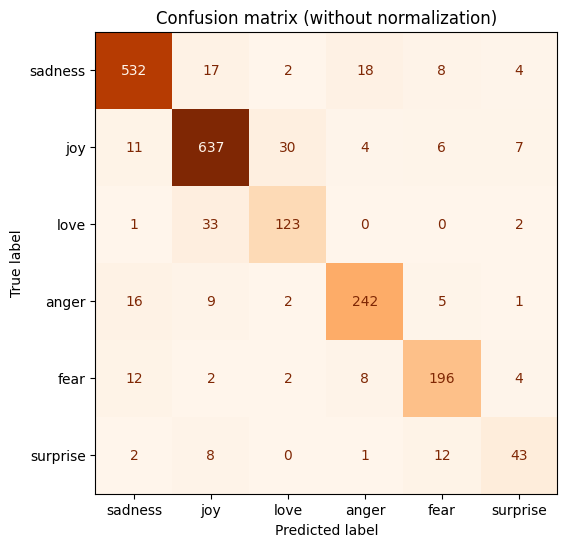

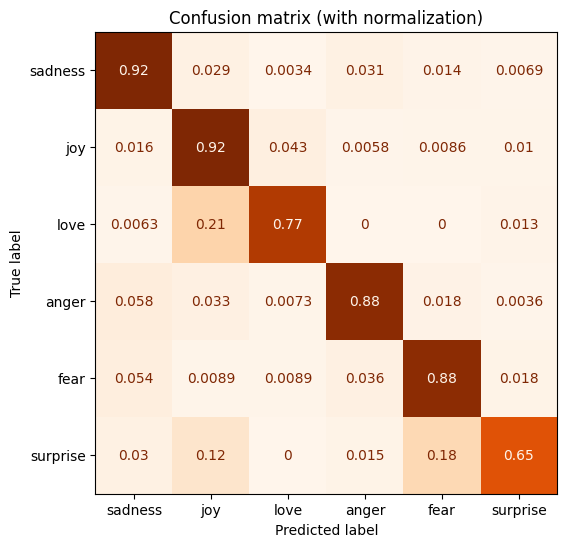

In [12]:
# this is the best result
SVM = svm.SVC(C=10, kernel='rbf', degree=3, gamma=0.1)
SVM.fit(train_X_Tfidf, train_labels)
predictions = SVM.predict(test_X_Tfidf)
print("Accuracy Score -> ", accuracy_score(predictions, test_labels)*100)
labels = ["sadness","joy", "love", "anger", "fear","surprise"]

def plot_confusion_matrix(predictions, test_labels, labels):
    cm = confusion_matrix(test_labels, predictions)
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Oranges", ax=ax, colorbar=False)
    plt.title("Confusion matrix (without normalization)")
    plt.show()


def plot_confusion_matrix_normalized(predictions, test_labels, labels):
    cm = confusion_matrix(test_labels, predictions, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Oranges", ax=ax, colorbar=False)
    plt.title("Confusion matrix (with normalization)")
    plt.show()

plot_confusion_matrix(predictions, test_labels, labels)
plot_confusion_matrix_normalized(predictions, test_labels, labels)